# Main imports and code

In [ ]:
# check which gpu we're using
!nvidia-smi

Sun Jan  9 18:06:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip  install transformers
!pip install pytorch-ignite

     |████████████████████████████████| 3.4 MB 10.8 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 35.8 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 251 kB 11.9 MB/s 


In [2]:
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from transformers import BertTokenizer,BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim import AdamW
from tqdm import tqdm
from argparse import ArgumentParser
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.engine.engine import Engine, State, Events
from ignite.handlers import EarlyStopping
from ignite.contrib.handlers import TensorboardLogger, ProgressBar
from ignite.utils import convert_tensor
from torch.optim.lr_scheduler import ExponentialLR
import warnings  
warnings.filterwarnings('ignore')

In [3]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

In [4]:
from transformers import AutoTokenizer, AutoModel, AdamW


In [5]:
!pip install sentencepiece


     |████████████████████████████████| 1.2 MB 11.8 MB/s 


In [6]:
import random
import os
from urllib import request

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df=pd.read_csv('/content/drive/MyDrive/ISarcasm/DataSet/train.Ar.csv')
df=df[['tweet','sarcastic']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1e611aed0>]],
      dtype=object)

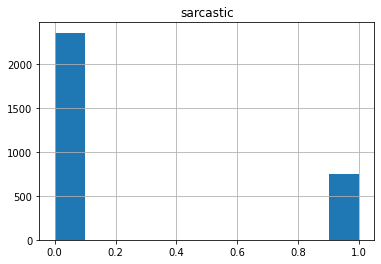

In [10]:
df.hist(column="sarcastic")


In [11]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [12]:
train=pd.concat([train, validate], ignore_index=True)

In [ ]:
# tedf1.to_csv('/content/drive/MyDrive/PCL/test_task_1',index=False)

In [ ]:
# trdf1.to_csv('/content/drive/MyDrive/PCL/train_task_1',index=False)

# RoBERTa Baseline for Task 1

In [13]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [14]:
!pip install datasets


     |████████████████████████████████| 306 kB 11.7 MB/s 
     |████████████████████████████████| 243 kB 48.7 MB/s 
     |████████████████████████████████| 133 kB 50.8 MB/s 
     |████████████████████████████████| 1.1 MB 53.2 MB/s 
     |████████████████████████████████| 160 kB 53.6 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
     |████████████████████████████████| 144 kB 50.5 MB/s 


In [15]:
class PCLTrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_length,displacemnt):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['tweet'].values
        self.label=df['sarcastic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        # summary = self.summary[index]
        inputs_text = self.tokenizer.encode_plus(
                                text,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        
                            
        target = self.label[index]
        
        text_ids = inputs_text['input_ids']
        text_mask = inputs_text['attention_mask']
        
       
        
        
        return {
            
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [16]:
import math
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [17]:
class Recall_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        # assert y_pred.ndim == 2
        # assert y_true.ndim == 1
        # print(y_pred.shape)
        # print(y_true.shape)
        # y_pred[y_pred<0.5]=0
        # y_pred[y_pred>=0.5]=0


        
        y_true_one_hot = F.one_hot(y_true.to(torch.int64), 2).to(torch.float32)
        # y_pred_one_hot = F.one_hot(y_pred.to(torch.int64), 2).to(torch.float32)
        
        tp = (y_true_one_hot * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true_one_hot) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true_one_hot) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true_one_hot * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        # f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        # f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        # f1=f1.detach()
        # print(f1.shape)
        # y_pred=y_pred.reshape((y_pred.shape[0], 1))
        # y_true=y_true.reshape((y_true.shape[0], 1))

        # p1=y_true*(math.log(sigmoid(y_pred)))*(1-f1)[1]
        # p0=(1-y_true)*math.log(1-sigmoid(y_pred))*(1-f1)[0]


        # y_true_one_hot = F.one_hot(y_true.to(torch.int64), 2)
        # print(y_pred)
        # print(y_true_one_hot)
        recall=recall.detach()
        CE =torch.nn.CrossEntropyLoss(weight=( 1 - recall))(y_pred, y_true_one_hot)
        # loss = ( 1 - f1)  * CE
        return  CE.mean()

In [18]:
class PCL_Model_Arch(nn.Module):
    def __init__(self,pre_trained='UBC-NLP/MARBERT'):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(pre_trained, output_hidden_states=True)
        output_channel = 16  # number of kernels
        num_classes = 2  # number of targets to predict
        dropout = 0.2  # dropout value
        embedding_dim = 768   # length of embedding dim

        ks = 3  # three conv nets here

        # input_channel = word embeddings at a value of 1; 3 for RGB images
        input_channel = 4  # for single embedding, input_channel = 1

        # [3, 4, 5] = window height
        # padding = padding to account for height of search window

        # 3 convolutional nets
        self.conv1 = nn.Conv2d(input_channel, output_channel, (3, embedding_dim), padding=(2, 0), groups=4)
        self.conv2 = nn.Conv2d(input_channel, output_channel, (4, embedding_dim), padding=(3, 0), groups=4)
        self.conv3 = nn.Conv2d(input_channel, output_channel, (5, embedding_dim), padding=(4, 0), groups=4)

        # apply dropout
        self.dropout = nn.Dropout(dropout)

        # fully connected layer for classification
        # 3x conv nets * output channel
        self.fc1 = nn.Linear(ks * output_channel, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        # get the last 4 layers
        outputs= self.bert(text_id, attention_mask=text_mask)
        # all_layers  = [4, 16, 256, 768]
        hidden_layers = outputs[2]  # get hidden layers

        hidden_layers = torch.stack(hidden_layers, dim=1)
        x = hidden_layers[:, -4:] 
        # x = x.unsqueeze(1)
        # x = torch.mean(x, 0)
        # print(hidden_layers.size())
      
        torch.cuda.empty_cache()
        x = [F.relu(self.conv1(x)).squeeze(3), F.relu(self.conv2(x)).squeeze(3), F.relu(self.conv3(x)).squeeze(3)]
        # max-over-time pooling; # (batch, channel_output) * ks
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        # concat results; (batch, channel_output * ks)
        x = torch.cat(x, 1)
        # add dropout
        x = self.dropout(x)
        # generate logits (batch, target_size)
        logit = self.fc1(x)
        torch.cuda.empty_cache()
        return self.softmax(logit)

In [ ]:
# class PCL_Model_Arch(nn.Module):

#     def __init__(self):
#         super(PCL_Model_Arch, self).__init__()
#         self.bert = AutoModel.from_pretrained('google/canine-c', output_hidden_states=False)
#         self.drop = nn.Dropout(p=0.2)
#         self.fc = nn.Linear(768, 2)

        
#         self.softmax = nn.Softmax()

#     def forward(self, text_id, text_mask):
#         # get the last 4 layers
#         outputs= self.bert(text_id, attention_mask=text_mask)
#         # all_layers  = [4, 16, 256, 768]
#         hidden_layers = outputs[1]  # get hidden layers
#         torch.cuda.empty_cache()

        
#         x = self.drop(hidden_layers)
#         torch.cuda.empty_cache()
#         # generate logits (batch, target_size)
#         logit = self.fc(x)
#         torch.cuda.empty_cache()
#         return self.softmax(logit)

In [19]:
!pip install emoji

     |████████████████████████████████| 174 kB 12.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=659fd2ea15b38799fade4c72e815a485b149dbd8aae82f8824350150f8f4e99c
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [20]:
tokenizer= AutoTokenizer.from_pretrained('UBC-NLP/MARBERT')


Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
def criterion(outputs1,  targets):

    criterion = Recall_Loss()
    loss = criterion(outputs1, targets)
    return loss

In [22]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """
    Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset.sarcastic))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, id_):
        return dataset.sarcastic[id_]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [23]:
CONFIG = {"seed": 2021,
          "epochs": 3,
          "model_name": "xlnet-base-cased",
          "train_batch_size": 16,
          "valid_batch_size": 64,
          "max_length": 120,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }

In [24]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        # print(text_ids.shape)
        
        batch_size = text_ids.size(0)
        # print(targets)

        outputs = model(text_ids, text_mask)
        # print(outputs.shape)
        
        # print(outputs.shape)

        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [25]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        # print(text_ids.shape)
        
        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
        # outputs = outputs.argmax(dim=1)
        
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

In [26]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
       
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print("Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [27]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [28]:
def prepare_loaders(fold):
    displacemnt_list=[0,512,1024,1536,2048,2560,3072,3584,4096,4608,4950]
    df_train = train[train.kfold != fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)
    sampler = ImbalancedDatasetSampler(df_train)
    
    train_dataset = PCLTrainDataset(df_train, tokenizer=tokenizer, max_length=CONFIG['max_length'],displacemnt=displacemnt_list[fold])
    valid_dataset = PCLTrainDataset(df_valid, tokenizer=tokenizer, max_length=CONFIG['max_length'],displacemnt=displacemnt_list[fold])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True, drop_last=True,sampler=sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [29]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=train, y=train.sarcastic)):
    train.loc[val_ , "kfold"] = int(fold)
    
train["kfold"] = train["kfold"].astype(int)

In [ ]:
# del model,train_loader, valid_loader

In [30]:
import gc
gc.collect()

170

http://seekinginference.com/applied_nlp/bert-cnn.html

In [31]:
for fold in range(0, CONFIG['n_fold']):
    print(f"====== Fold: {fold} ======")

    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = PCL_Model_Arch()
    model.to(CONFIG['device'])
    torch.cuda.empty_cache()
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

====== Fold: 0 ======


Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla K80



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=1, LR=8.57e-5, Valid_Loss=0.0706]


Validation Loss Improved (inf ---> 0.0706240679971289)
Model Saved



100%|██████████| 8/8 [00:09<00:00,  1.13s/it, Epoch=2, LR=5.11e-5, Valid_Loss=0.0592]


Validation Loss Improved (0.0706240679971289 ---> 0.059197661929746986)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.11s/it, Epoch=3, LR=1.62e-5, Valid_Loss=0.0592]



Training complete in 0h 19m 22s
Best Loss: 0.0592

====== Fold: 1 ======


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla K80



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=1, LR=8.57e-5, Valid_Loss=0.111]


Validation Loss Improved (inf ---> 0.11060592291816589)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.11s/it, Epoch=2, LR=5.11e-5, Valid_Loss=0.0637]


Validation Loss Improved (0.11060592291816589 ---> 0.0636647330416787)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=3, LR=1.62e-5, Valid_Loss=0.0739]



Training complete in 0h 19m 20s
Best Loss: 0.0637

====== Fold: 2 ======


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla K80



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=1, LR=8.57e-5, Valid_Loss=0.0527]


Validation Loss Improved (inf ---> 0.052689827497928374)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.11s/it, Epoch=2, LR=5.11e-5, Valid_Loss=0.0602]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it, Epoch=3, LR=1.62e-5, Valid_Loss=0.0654]



Training complete in 0h 19m 23s
Best Loss: 0.0527

====== Fold: 3 ======


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla K80



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=1, LR=8.57e-5, Valid_Loss=0.102]


Validation Loss Improved (inf ---> 0.10175012220298091)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=2, LR=5.11e-5, Valid_Loss=0.0468]


Validation Loss Improved (0.10175012220298091 ---> 0.04684209655369482)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=3, LR=1.62e-5, Valid_Loss=0.0478]



Training complete in 0h 19m 26s
Best Loss: 0.0468

====== Fold: 4 ======


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla K80



100%|██████████| 8/8 [00:08<00:00,  1.12s/it, Epoch=1, LR=8.57e-5, Valid_Loss=0.13]


Validation Loss Improved (inf ---> 0.13048978294095687)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.11s/it, Epoch=2, LR=5.11e-5, Valid_Loss=0.115]


Validation Loss Improved (0.13048978294095687 ---> 0.11521857592367357)
Model Saved



100%|██████████| 8/8 [00:08<00:00,  1.11s/it, Epoch=3, LR=1.62e-5, Valid_Loss=0.105]


Validation Loss Improved (0.11521857592367357 ---> 0.10452605783939362)
Model Saved

Training complete in 0h 19m 29s
Best Loss: 0.1045



In [32]:
test.dropna(inplace=True)

In [33]:
valid_dataset = PCLTrainDataset(test, tokenizer=tokenizer, max_length=CONFIG['max_length'],displacemnt=0)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

In [34]:
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['text_ids'].to(device, dtype = torch.long)
        mask = data['text_mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        # outputs = outputs.argmax(dim=1)
#         print(len(outputs))
#         print(len(np.max(outputs.cpu().detach().numpy(),axis=1)))
        PREDS.append(outputs.detach().cpu().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

In [35]:
def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = PCL_Model_Arch()
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    final_preds= np.argmax(final_preds,axis=1)
    return final_preds

In [36]:
MODEL_PATH_2=['/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-0.bin','/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-1.bin','/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-2.bin','/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-3.bin','/content/drive/MyDrive/ISarcasm/Tasks/Ar_models/marbert_recall_loss_imabalance_sampler/Loss-Fold-4.bin']
preds = inference(MODEL_PATH_2, valid_loader, CONFIG['device'])

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 2


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 3


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 4


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 5


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [37]:
from sklearn.metrics import jaccard_score,f1_score,accuracy_score,recall_score,precision_score,classification_report
def print_statistics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision =precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f_score = f1_score(y, y_pred, average='weighted')
    print('Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF_score: %.3f\n'
          % (accuracy, precision, recall, f_score))
    print(classification_report(y, y_pred))
    return accuracy, precision, recall, f_score

In [38]:
print(print_statistics(test['sarcastic'],preds))

Accuracy: 0.878
Precision: 0.889
Recall: 0.878
F_score: 0.881

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       486
           1       0.68      0.81      0.74       135

    accuracy                           0.88       621
   macro avg       0.81      0.85      0.83       621
weighted avg       0.89      0.88      0.88       621

(0.8776167471819646, 0.8886038347285985, 0.8776167471819646, 0.8813098878821832)


## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

In [ ]:
!cat task2.txt | head -n 10

In [ ]:
!zip submission.zip task1.txt task2.txt